In [1]:
%matplotlib inline
from pycocotools.coco import COCO
import os
import numpy as np
import random
import skimage.io as io
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pylab
import tensorflow as tf
import tensorflow.contrib.slim as slim
import tensorflow.contrib.slim.nets
from tensorflow.contrib.layers.python.layers import utils

import resnet_v2 as resnet
# import cv2
pylab.rcParams['figure.figsize'] = (10.0, 8.0)


In [2]:
def keypoint_CrossEntropyLoss(prediction_maps, keypoint_masks, labels, L=5.0, scope="keypointLoss"):
    """
    heat_maps = predictions from network
    keypoints (N,17,2) = actual keypoint locations
    labels (N,17,1) = 0 if invalid, 1 if occluded, 2 if valid
    """
    losses = tf.nn.sigmoid_cross_entropy_with_logits(logits=prediction_maps,labels=keypoint_masks)
    labels = tf.reshape(labels,[-1,1,1,17])
    losses = tf.multiply(losses,labels) # set loss to zero for invalid keypoints (labels=0)
    
    return losses

In [3]:
def keypoint_SquaredErrorLoss(prediction_maps, keypoint_masks, labels, L=5.0, scope="keypointLoss"):
    """
    heat_maps = predictions from network
    keypoints (N,17,2) = actual keypoint locations
    labels (N,17,1) = 0 if invalid, 1 if occluded, 2 if valid
    """
    losses = tf.squared_difference(prediction_maps,keypoint_masks)
    labels = tf.reshape(labels,[-1,1,1,17])
    losses = tf.multiply(losses,labels) # set loss to zero for invalid keypoints (labels=0)
    
    return losses

# Initialize Dataset

In [4]:
def get_data(base_dir,image_dir,ann_file):
    image_path = '{}/images/{}'.format(baseDir,image_dir)
    ann_path='{}/annotations/{}.json'.format(baseDir,ann_file)

    return image_path, ann_path
    
# define the path to the annotation file corresponding to the images you want to work with
baseDir='/Users/kyle/Repositories/coco'

trainData='person_keypoints_train2014'
valData='person_keypoints_val2014'
testData='image_info_test-dev2015'

imageTrainDir = 'train2014'
imageValDir = 'val2014'
imageTestDir = 'test2015'

train_img_path, train_ann_path = get_data(baseDir,imageTrainDir,trainData)
val_img_path, val_ann_path = get_data(baseDir,imageValDir,valData)
# initialize a coco object
print("Initializing COCO objects to extract training and validation datasets...\n")
train_coco = COCO(train_ann_path)
val_coco = COCO(val_ann_path)
# get all images containing the 'person' category
train_catIds = train_coco.getCatIds(catNms=['person'])
train_imgIds = train_coco.getImgIds(catIds=train_catIds)
val_catIds = val_coco.getCatIds(catNms=['person'])
val_imgIds = val_coco.getImgIds(catIds=val_catIds)
# Just for dealing with the images on my computer (not necessary when working with the whole dataset)
# if args.small_dataset:
train_catIds = train_catIds[0:30]
train_imgIds = train_imgIds[0:30]
val_catIds = val_catIds[0:30]
val_imgIds = val_imgIds[0:30]


Initializing COCO objects to extract training and validation datasets...

loading annotations into memory...
Done (t=11.17s)
creating index...
index created!
loading annotations into memory...
Done (t=4.54s)
creating index...
index created!


In [14]:
#######################################################
############### VARIOUS HYPER-PARAMETERS ##############
#######################################################

NUM_KEYPOINTS = 17
BATCH_SIZE = 5 #args.batch_size
L = 5.0 # keypoint effective radius
D = 224 # image height and width
d = 56 # evaluation height and width (for mask and keypoint masks)

MASK_THRESHOLD = 0.5 # threshold for on/off prediction (in mask and keypoint masks)
KP_THRESHOLD = 0.5 # threshold for on/off prediction (in mask and keypoint masks)
KP_DISTANCE_THRESHOLD = 5.0 # threshold for determining if a keypoint estimate is accurate
X_INIT = tf.contrib.layers.xavier_initializer_conv2d() # xavier initializer for head architecture
# learning_rate1 = args.learning_rate1
# learning_rate2 = args.learning_rate2

#######################################################
#### VISUALIZATION TOOLS - WEIGHTS AND ACTIVATIONS ####
#######################################################
def highestPrimeFactorization(n):    
    return [(i, n//i) for i in range(1, int(n**0.5) + 1) if n % i == 0][-1] 

def getFilterImage(filters):
    """
    Takes as input a filter bank of size (1, H, W, C, D)
    Returns: a tensor of size (1, sqrt(D)*H, sqrt(D)*H, C)
    (This only really works for the first layer of filtes with an image as input)
    """
    padded_filters = tf.pad(filters,tf.constant([[0,0],[1,0],[1,0],[0,0],[0,0]]),'CONSTANT')
    filter_list = tf.unstack(padded_filters,axis=4)
    H,W = highestPrimeFactorization(len(filter_list))
    weight_strips = [tf.concat(filter_list[8*i:8*(i+1)],axis=1) for i in range(W)]
    weight_image = tf.concat(weight_strips,axis=2)
    return weight_image

def getActivationImage(activations):
    """
    Tiles an activation map into a square grayscale image
    Takes as input an activation map of size (N, H, W, D)
    Returns: a tensor of size (N, sqrt(D)*H, sqrt(D)*H, 1)
    """
    padded_activations = tf.pad(activations,tf.constant([[0,0],[1,0],[1,0],[0,0]]),'CONSTANT')
    expanded_activations = tf.expand_dims(padded_activations,axis=3)
    activations_list = tf.unstack(expanded_activations,axis=4)
    H,W = highestPrimeFactorization(len(activations_list))
    activation_strips = [tf.concat(activations_list[H*i:H*(i+1)],axis=1) for i in range(W)]
    activation_image = tf.concat(activation_strips,axis=2)
    return activation_image
#######################################################
##### PRE-PROCESSING AND DATASET EXTRACTION TOOLS #####
#######################################################
def extract_annotations_train(filename, imgID, coco=train_coco):
    anns = coco.loadAnns(coco.getAnnIds(imgID,catIds=[1],iscrowd=None))
    ann = max([ann for ann in anns], key=lambda item:item['area']) # extract annotation for biggest instance
    bbox = np.array(np.floor(ann['bbox']),dtype=int)
    keypoints = np.reshape(ann['keypoints'],(-1,3))
    mask = coco.annToMask(ann)
    return filename, bbox, keypoints, mask

def extract_annotations_val(filename, imgID, coco=val_coco):
    anns = coco.loadAnns(coco.getAnnIds(imgID,catIds=[1],iscrowd=None))
    ann = max([ann for ann in anns], key=lambda item:item['area']) # extract annotation for biggest instance
    bbox = np.array(np.floor(ann['bbox']),dtype=int)
    keypoints = np.reshape(ann['keypoints'],(-1,3))
    mask = coco.annToMask(ann)
    return filename, bbox, keypoints, mask

def preprocess_image_tf(filename, bbox_tensor, keypoints_tensor, mask, D=D):
    """
    Returns:
    resized_image (N,D,D,3) - cropped, padded (if needed), scaled to square image of size D
    resized_mask (N,D,D,1) - cropped, padded (if needed), scaled to square mask of size D
    pts (N,2,17) - keypoint coordinates (i,j) scaled to match up with resized_image
    labels (N,1,17) - values corresponding to pts: {0: invalid, 1:occluded, 2:valid}
    """
    image_string = tf.read_file(filename)
    image_decoded = tf.image.decode_jpeg(image_string, channels=3)
    image = tf.cast(image_decoded, tf.float32)

    mask = tf.transpose([mask],[1,2,0])
    bbox_tensor = tf.to_float(bbox_tensor)
    keypoints_tensor = tf.to_float(keypoints_tensor)

    sideLength = tf.reduce_max(bbox_tensor[2:],axis=0)
    centerX = tf.floor(bbox_tensor[0] + tf.divide(bbox_tensor[2],tf.constant(2.0)))
    centerY = tf.floor(bbox_tensor[1] + tf.divide(bbox_tensor[3],tf.constant(2.0)))
    center = tf.stack([centerX,centerY])

    corner1 = tf.to_int32(tf.minimum(tf.maximum(tf.subtract(center, tf.divide(sideLength,tf.constant(2.0))),0),
                        tf.reverse(tf.to_float(tf.shape(image)[:2]),tf.constant([0]))))
    corner2 = tf.to_int32(tf.minimum(tf.maximum(tf.add(center, tf.divide(sideLength,tf.constant(2.0))),0),
                        tf.reverse(tf.to_float(tf.shape(image)[:2]),tf.constant([0]))))
    i_shape = tf.subtract(corner2,corner1)
    d_shape = tf.subtract(tf.to_int32(sideLength),i_shape)

    scale = tf.divide(tf.constant(D,tf.float32), sideLength)
    cropped_image = tf.image.crop_to_bounding_box(image,corner1[1],corner1[0],
                                                tf.subtract(corner2,corner1)[1],tf.subtract(corner2,corner1)[0])
    cropped_mask = tf.image.crop_to_bounding_box(mask,corner1[1],corner1[0],
                                                tf.subtract(corner2,corner1)[1],tf.subtract(corner2,corner1)[0])

    dX = tf.floor(tf.divide(d_shape,tf.constant(2)))
    dY = tf.ceil(tf.divide(d_shape,tf.constant(2)))

    pts, labels = tf.split(keypoints_tensor,[2,1],axis=1)
    pts = tf.subtract(pts,tf.to_float(corner1)) # shift keypoints
    pts = tf.add(pts,tf.to_float(dX)) # shift keypoints
    pts = tf.multiply(pts,scale) # scale keypoints

    # set invalid pts to 0
    inbounds = tf.less(pts,tf.constant(D,tf.float32))
    inbounds = tf.multiply(tf.to_int32(inbounds), tf.to_int32(tf.greater(pts,0)))
    pts = tf.multiply(pts,tf.to_float(inbounds))
    pts = tf.transpose(pts,[1,0])
    labels = tf.transpose(labels,[1,0])

    padded_image = tf.image.pad_to_bounding_box(cropped_image,tf.to_int32(dX[1]),tf.to_int32(dX[0]),
                                                tf.to_int32(sideLength),tf.to_int32(sideLength))
    padded_mask = tf.image.pad_to_bounding_box(cropped_mask,tf.to_int32(dX[1]),tf.to_int32(dX[0]),
                                                tf.to_int32(sideLength),tf.to_int32(sideLength))

    resized_image = tf.image.resize_images(padded_image,tf.constant([D,D]),tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    # resized_image = resized_image - VGG_MEAN
    resized_mask = tf.image.resize_images(padded_mask,tf.constant([D,D]),tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    return resized_image, resized_mask, pts, labels

def scaleDownMaskAndKeypoints(image, mask, pts, labels, d=d, D=D):
    mask = tf.image.resize_images(mask,tf.constant([d,d]),tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    pts = tf.multiply(pts,tf.constant(d/D))
    return image, mask, pts, labels

def generate_keypoint_masks(image, mask, keypoints, labels, d=d, D=D, L=L):
    X, Y = tf.meshgrid(tf.linspace(0.0,d,d),tf.linspace(0.0,d,d))
    X = tf.reshape(X,[d,d,1])
    Y = tf.reshape(Y,[d,d,1])
    X_stack = tf.tile(X,tf.constant([1,1,17],dtype=tf.int32))
    Y_stack = tf.tile(Y,tf.constant([1,1,17],dtype=tf.int32))

    pts = tf.reshape(keypoints,[1,2,17])
    ptsX, ptsY = tf.split(pts,[1,1],axis=1)
    d1 = tf.square(tf.subtract(X_stack,ptsX))
    d2 = tf.square(tf.subtract(Y_stack,ptsY))

    pt_masks = tf.multiply(tf.divide(tf.constant(1.0),tf.add(d1,d2)+L),L)

    return image, mask, pt_masks, pts, labels

def generate_one_hot_keypoint_masks(image, mask, keypoints, labels, d=d):
    pts = tf.reshape(keypoints,[1,2,17])
    indices = tf.to_int32(pts)
    kp_mask1 = tf.one_hot(depth=d,indices=indices[:,1,:],axis=0)
    kp_mask2 = tf.one_hot(depth=d,indices=indices[:,0,:],axis=1)
    kp_masks = tf.matmul(tf.transpose(kp_mask1,(2,0,1)),tf.transpose(kp_mask2,(2,0,1)))
    kp_masks = tf.transpose(kp_masks,(1,2,0))
    return image, mask, kp_masks, pts, labels



#######################################################
################## SUMMARY DICTIONARY #################
#######################################################

image_summary_list = []
scalar_summary_list = []

#######################################################
################### PREPARE DATASET ###################
#######################################################
print("Initializing Dataset...\n")
with tf.variable_scope('DataSet'):
    ################### TRAIN DATASET ###################
    train_filenames = tf.constant(['{}/COCO_train2014_{:0>12}.jpg'.format(train_img_path, imgID) for imgID in train_imgIds])
    train_imgID_tensor = tf.constant(train_imgIds)
    train_dataset = tf.contrib.data.Dataset.from_tensor_slices((train_filenames, train_imgID_tensor))
    train_dataset = train_dataset.map(
        lambda filename, imgID: tf.py_func(extract_annotations_train, [filename, imgID], [filename.dtype, tf.int64, tf.int64, tf.uint8]))
    train_dataset = train_dataset.map(preprocess_image_tf)
    train_dataset = train_dataset.map(scaleDownMaskAndKeypoints)
    train_dataset = train_dataset.map(generate_one_hot_keypoint_masks)
    train_dataset = train_dataset.shuffle(buffer_size=10000)
    train_dataset = train_dataset.batch(BATCH_SIZE)

    #################### VAL DATASET ####################
    val_filenames = tf.constant(['{}/COCO_val2014_{:0>12}.jpg'.format(val_img_path, imgID) for imgID in val_imgIds])
    val_imgID_tensor = tf.constant(val_imgIds)
    val_dataset = tf.contrib.data.Dataset.from_tensor_slices((val_filenames, val_imgID_tensor))
    val_dataset = val_dataset.map(
        lambda filename, imgID: tf.py_func(extract_annotations_val,[filename, imgID],[filename.dtype, tf.int64, tf.int64, tf.uint8]))
    val_dataset = val_dataset.map(preprocess_image_tf)
    val_dataset = val_dataset.map(scaleDownMaskAndKeypoints)
    val_dataset = val_dataset.map(generate_one_hot_keypoint_masks)
    val_dataset = val_dataset.shuffle(buffer_size=10000)
    val_dataset = val_dataset.batch(BATCH_SIZE)

    iterator = tf.contrib.data.Iterator.from_structure(train_dataset.output_types, train_dataset.output_shapes)

    images, masks, kpt_masks, pts, labels = iterator.get_next()
    train_init_op = iterator.make_initializer(train_dataset)
    val_init_op = iterator.make_initializer(val_dataset)

    image_summary_list.append(tf.summary.image('keypoint_masks', getActivationImage(kpt_masks)))
    image_summary_list.append(tf.summary.image('input_images', images))

#######################################################
print("done")

Initializing Dataset...

done


### Keypoint One-hot masks

In [15]:
sess = tf.InteractiveSession()

In [24]:
sess.run(train_init_op)

In [25]:
depth = 56
indices = tf.to_int32(tf.divide(pts,2.0))
kp_mask1 = tf.one_hot(depth=depth,indices=indices[:,:,1,:],axis=1)
kp_mask2 = tf.one_hot(depth=depth,indices=indices[:,:,0,:],axis=2)
kp_mask = tf.matmul(tf.transpose(kp_mask1,(0,3,1,2)),tf.transpose(kp_mask2,(0,3,1,2)))
kp_mask = tf.transpose(kp_mask,(0,2,3,1))


In [26]:
def keypointOneHotMasks(pts,d=d):
    indices = tf.to_int32(pts)
    kp_mask1 = tf.one_hot(depth=d,indices=indices[:,:,1,:],axis=1)
    kp_mask2 = tf.one_hot(depth=d,indices=indices[:,:,0,:],axis=2)
    kp_mask = tf.matmul(tf.transpose(kp_mask1,(0,3,1,2)),tf.transpose(kp_mask2,(0,3,1,2)))
    kp_mask = tf.transpose(kp_mask,(0,2,3,1))
    return kp_mask

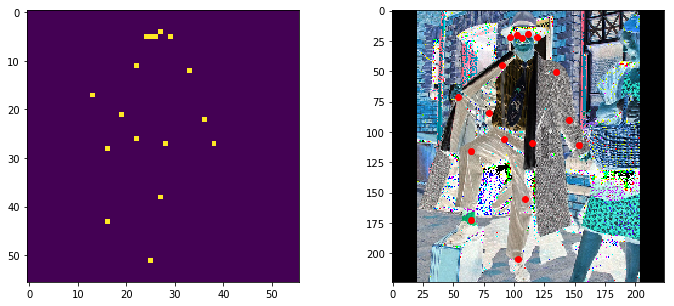

In [27]:
I,M,KPM,KP,L = sess.run([images, masks, kpt_masks, pts, labels])
KPM[0,0,:,:] = 0
KPM[0,:,0,:] = 0
plt.figure(figsize=[12,5])
plt.subplot(1,2,1)
plt.imshow(np.sum(KPM[0],axis=2))
plt.subplot(1,2,2)
plt.imshow(I[0])
plt.scatter((D/d)*KP[0][0,0,:],(D/d)*KP[0][0,1,:],c="r")